In [152]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import *
from utils.functions import *

### Test case "Gaussian"

[[0.5 0. ]
 [0.  0.5]]


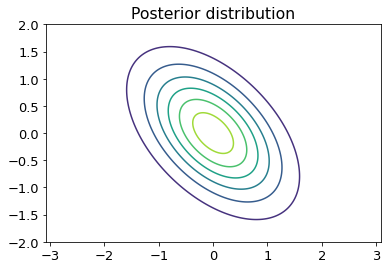

In [153]:
d = 2

y = np.zeros(1)
xmin = -2
xmax = 2
ymin= -2
ymax= 2


# potential function
sigNoise = 1
sigPrior = 1

A = np.asarray([[1,0], [0,1]])
G = lambda u:  u[0] + u[1] # model
#G = lambda u: u[0]*A[0,0] + u[1]*A(1,1)
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
I = lambda u: 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2 + Phi(u)

# compute Sigma posterior (the target covariance matrix)

K_inv = np.eye(d,d)*(1/sigPrior**2) + functools.reduce(np.dot, [A.T, np.eye(d,d)*(1/sigNoise**2),A])
K = np.linalg.solve(K_inv,np.eye(d,d))
print(K)

# plot posterior

u0s = np.linspace(xmin,xmax,150) # draw a grid of 150 points in 2d
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1)) # size (2, 150, 150)
#print(U.shape)

plt.figure()
plt.contour(U0, U1, np.exp(-I(U))) 
plt.title("Posterior distribution")
plt.axis('equal')
plt.show()


In [114]:
U.shape

(2, 150, 150)

In [132]:
print(K_inv)
print(np.trace(K_inv))

print(K)

[[2. 0.]
 [0. 2.]]
4.0
[[0.5 0. ]
 [0.  0.5]]


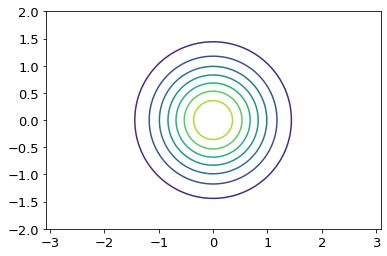

In [138]:
# compare with Gaussian with covariance K given by the formula

m = np.array([[0],[0]])  # defining the mean of the Gaussian (mX = 0.2, mY=0.6)
#cov = np.array([[0.5, -0.3], [-0.3, 0.5]])   # defining the covariance matrix
cov = K
cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
cov_det = np.linalg.det(cov)  # determinant of covariance matrix
# Plotting
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
X,Y = U0,U1
coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
plt.contour(X,Y,Z)
plt.axis('equal')
plt.show()

### Try algorithms

In [154]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 3000 # number of iterations
d = 2 # dimension
tau = 1e-3 # step size

# parameters of our algorithm
const = 1.5 


Text(0.5, 1.0, 'Posterior distribution and initialization')

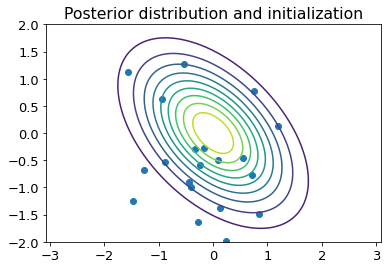

In [155]:
# initial position of the particles

u0 = np.random.normal(0,1.0,(d,J)) 

plt.figure()
plt.contour(U0, U1, np.exp(-I(U)), 10)
plt.scatter(u0[0],u0[1])
plt.axis('equal')
plt.title("Posterior distribution and initialization")

In [156]:
# ULA
start_time = time.time()
us_list_ULA = run_ULA(I, N_sim, u0, tau)
np.save('save_data/gaussian/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ULA)
print(f"ULA: {time.time()-start_time} seconds")

# ALDI 
start_time = time.time()
us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
np.save('save_data/gaussian/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                    +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ALDI)
print(f"ALDI with gradient: {time.time()-start_time} seconds")


# NRALDI (our scheme)
# eventually new parameters like stepsize

tau_ALDINR = 1e-3
#tau_ALDINR = tau

start_time = time.time()
us_list_ALDINR, preconditioners = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 


# save data
np.save('save_data/gaussian/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'.npy', us_list_ALDINR)

np.save('save_data/gaussian/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)\
                      +'_preconditioners'+'.npy', preconditioners)

print(f"ALDI NR: {time.time()-start_time} seconds")


ULA: 25.323884963989258 seconds
ALDI with gradient: 25.8876850605011 seconds
iter
0
lambda min
0.529369605402797
trace D opt
2.0



/Users/annakorba/Desktop/nreks/utils/algorithms.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:,:,n+1] = us+tau*drift  + np.sqrt(tau)*diff


iter
100
lambda min
0.20973870635703656
trace D opt
2.0

iter
200
lambda min
0.24262725125387083
trace D opt
1.9999999999999996

iter
300
lambda min
0.3343185370613801
trace D opt
1.9999999999999998

iter
400
lambda min
0.2979209445319102
trace D opt
2.0000000000000004

iter
500
lambda min
0.2644769529049487
trace D opt
2.0

iter
600
lambda min
0.20575763759809654
trace D opt
2.0

iter
700
lambda min
0.3095745315654441
trace D opt
1.9999999999999996

iter
800
lambda min
0.47352110664670793
trace D opt
2.0000000000000004

iter
900
lambda min
0.29529156474649254
trace D opt
1.9999999999999996

iter
1000
lambda min
0.21973343984283483
trace D opt
2.0

iter
1100
lambda min
0.2649173306338225
trace D opt
2.0

iter
1200
lambda min
0.3110223449577173
trace D opt
1.9999999999999996

iter
1300
lambda min
0.3512477234339623
trace D opt
2.0

iter
1400
lambda min
0.42926042093472105
trace D opt
1.9999999999999996

iter
1500
lambda min
0.36385334033971156
trace D opt
2.0000000000000004

iter
1600
l

In [171]:
# load data


us_list_ULA = np.load('save_data/gaussian/ULA_J_20_Nsim_3000_tau_0.001.npy')
us_list_ALDI = np.load('save_data/gaussian/ALDI_J_20_Nsim_3000_tau_0.001.npy')



us_list_ALDINR = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001_particles.npy')
means = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001_means.npy')
covariances = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001_covariances.npy')
preconditioners = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001_preconditioners.npy')



ValueError: operands could not be broadcast together with shapes (150,150) (3000,) 

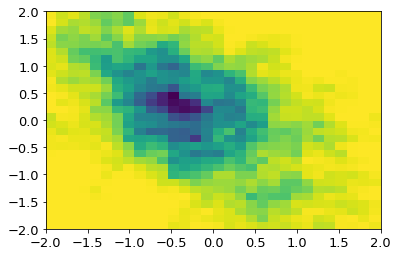

In [172]:
# plot results

    
name = nameof(us_list_ULA).lstrip('us_list')
plot_results(I, us_list_ULA, tau, name)
plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0], color = "purple")
plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red")


name = nameof(us_list_ALDI).lstrip('us_list')
plot_results(I, us_list_ALDI, tau, name)
plt.scatter(u0[0],u0[1], color = "purple")
plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple")
plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red")

    
name = nameof(us_list_ALDINR).lstrip('us_list')
plot_results(I, us_list_ALDINR, tau_ALDINR, name)
plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple")
plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red")



## Plot some statistics for ALDINR

### What about the trace of T (the preconditioner) , the step size and ALDI?

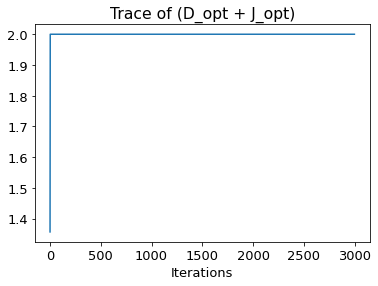

tau ALDINR
0.001
tau ALDI
0.001
tau ALDI times d 
0.002


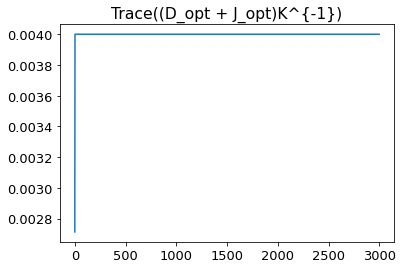

In [159]:
# plot Trace of T = (D_opt + J_opt)


y = np.trace(preconditioners)
y.shape
plt.plot(y)
plt.title('Trace of (D_opt + J_opt)')
plt.xlabel('Iterations')
plt.show()
# it seems that Trace(T) = d

a = [tau_ALDINR * np.trace(np.dot(preconditioners[:, :, i], K_inv)) for i in range(preconditioners.shape[2])]
b = tau * d 
print("tau ALDINR")
print(tau_ALDINR)
print("tau ALDI")
print(tau)
print("tau ALDI times d ")
print(b)


plt.plot(a)
plt.title('Trace((D_opt + J_opt)K^{-1})')
plt.show()

(3000,)


Text(0.5, 1.0, 'ALDINR: Distance to mean (|| mean(particles) - mean(target)||)')

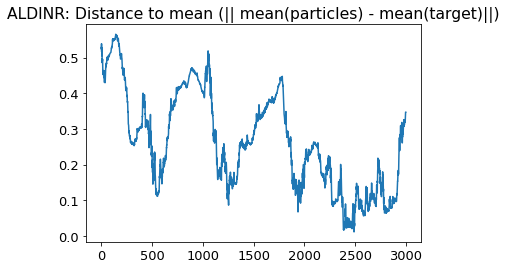

In [160]:
distances_to_mean = np.linalg.norm(means, axis=0)
print(distances_to_mean.shape)

plt.plot(distances_to_mean)
plt.title('ALDINR: Distance to mean (|| mean(particles) - mean(target)||)')

(2, 2, 3000)
(3000,)


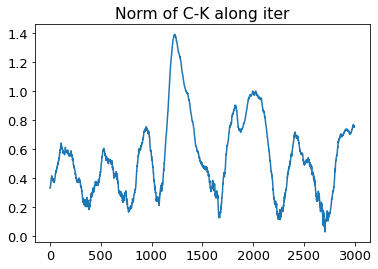

In [161]:
distances_to_covariances = np.asarray([np.linalg.norm(covariances[:, :, i]-K) for i in range(covariances.shape[2])])
print(covariances.shape)
print(distances_to_covariances.shape)
plt.title('Norm of C-K along iter')
plt.plot(distances_to_covariances)

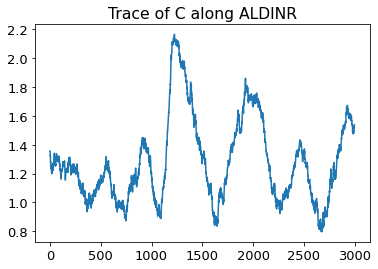

In [162]:
traces_of_C = np.asarray([np.trace(covariances[:, :, i]) for  i in range(covariances.shape[2])] )
plt.title('Trace of C along ALDINR')
plt.plot(traces_of_C)

In [7]:
#np.min(us_list_ALDINR[0,:,N_burnin:].flatten())

In [8]:
#np.max(us_list_ALDI3[0,:,N_burnin:].flatten())

In [9]:
#np.min(us_list_ALDI3[0,:,N_burnin:].flatten())

In [10]:
#plt.hist(us_list_ALDINR[0,:,N_burnin:].flatten())

In [11]:
#plt.hist(us_list_ALDI3[0,:,N_burnin:].flatten())

In [12]:
#us_list_ALDI3[0,:,N_burnin:].flatten()

In [13]:
#plt.hist2d(us_list_ALDINR[0,:,N_burnin:].flatten(),us_list_ALDINR[1,:,N_burnin:].flatten(),bins=200)

In [14]:
#plt.hist2d(us_list_ALDI3[0,:,N_burnin:].flatten(),us_list_ALDI3[1,:,N_burnin:].flatten(),bins=200)

In [15]:
#plt.plot(dist_M)
#plt.figure()
#plt.plot(dist_C)

In [16]:
#dist_M[1]